In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

np.random.seed(11132009)

In [71]:
import matplotlib.font_manager as fm
fpath = '../Personal Folders/Dan/futura_medium_condensed_bt.ttf'
futura = fm.FontProperties(fname=fpath)

FMF_Pallette = ["#5C5C5C","#46ACC8","#E2D200","#DD8D29","#E58601","#B40F20"]

## 1- What insights can we find by analyzing variable trends over the years?

In [2]:
data_1 = pd.read_csv("../Data/data_modified.csv")
data_1.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,explicit,key,mode,year,name,artists,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,0.995,0.514,172133,0.2560,0.00000,0.3490,-15.145,0,0.0871,79.467,0.574,0,0,1,1921,Si J'avais Su,['Alice Cocéa'],NaN,NaN,NaN
1,0.994,0.426,177733,0.2260,0.00000,0.2350,-16.126,0,0.0693,73.630,0.552,0,9,1,1921,Elle Porte Un Nom Charmant,['André Urban'],NaN,NaN,NaN
2,0.971,0.540,122000,0.0848,0.00196,0.0887,-16.055,0,0.0750,100.296,0.527,0,5,0,1921,A Ballynure Ballad,['Christopher Lynch'],NaN,NaN,NaN
3,0.950,0.607,163200,0.1380,0.00000,0.1140,-15.683,0,0.1570,113.282,0.511,0,3,1,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch'],NaN,NaN,NaN
4,0.969,0.344,120067,0.1310,0.00000,0.1450,-14.261,0,0.0616,178.212,0.257,0,10,0,1921,Just A Little Bit Of Heaven,['Christopher Lynch'],NaN,NaN,NaN


In [102]:
## DATA AGGREGATION ##

# CONTINUOUS VARIABLES #

cont_features_1 = ["acousticness", 
                   "danceability", 
                   "duration_ms", 
                   "energy", 
                   "instrumentalness", 
                   "liveness", 
                   "loudness", 
                   "popularity", 
                   "speechiness", 
                   "tempo", 
                   "valence"]
data_agg_cols_1 = ["year"] + cont_features_1
data_agg_1 = pd.DataFrame(columns = data_agg_cols_1)

# CATEGORICAL VARIABLES #

#Kyes
key_cols_1 = ["year", "key", "number", "percentage"]
key_distro_1 = pd.DataFrame(columns = key_cols_1)

#Mode
mode_cols_1 = ["year", "mode", "number", "percentage"]
mode_distro_1 = pd.DataFrame(columns = mode_cols_1)

#Explicit
explicit_cols_1 = ["year", "explicit", "number", "percentage"]
explicit_distro_1 = pd.DataFrame(columns = explicit_cols_1)

In [103]:
# Loop through each year
for i in range (1921, 2021):
    # Create a temporary dataframe for the year
    inYr = data_1["year"] == i
    yrDF = data_1.loc[inYr]
    
    ### CONTINUOUS VARIABLES ###
    
    data_agg_1 = data_agg_1.append(pd.DataFrame({"year" : [float(i)],
                                                 "acousticness": yrDF["acousticness"].mean(), 
                                                 "danceability": yrDF["danceability"].mean(), 
                                                 "duration_ms": yrDF["duration_ms"].mean(), 
                                                 "energy": yrDF["energy"].mean(), 
                                                 "instrumentalness": yrDF["instrumentalness"].mean(), 
                                                 "liveness": yrDF["liveness"].mean(), 
                                                 "loudness": yrDF["loudness"].mean(), 
                                                 "popularity": yrDF["popularity"].mean(), 
                                                 "speechiness": yrDF["speechiness"].mean(), 
                                                 "tempo": yrDF["tempo"].mean(), 
                                                 "valence": yrDF["valence"].mean()}))
    
    #### KYES ####
    
    # Count number of times each key is used in the year
    num_keys = np.array([0] * 12)
    
    for j in yrDF['key']:
        num_keys[j] = num_keys[j] + 1
    
    # Calculate percentage for each key
    percent_keys = num_keys / yrDF.shape[0]
    
    # Add each year/key pair to the key_distro_1 DF
    for j in range (0, 12):
        key_distro_1 = key_distro_1.append(pd.DataFrame({"year":[i],
                                                         "key": [j],
                                                         "number": [num_keys[j]],
                                                         "percentage": [percent_keys[j]]}))
        
    #### MODES ####
    
    # Count number of times each mode is used in the year
    num_modes = np.array([0] * 2)
    
    for j in yrDF['mode']:
        num_modes[j] = num_modes[j] + 1
    
    # Calculate percentage for each mode
    percent_modes = num_modes / yrDF.shape[0]
    
    # Add each year/mode pair to the mode_distro_1 DF
    for j in range (1, 2):
        mode_distro_1 = mode_distro_1.append(pd.DataFrame({"year":[i],
                                                           "mode": [j],
                                                           "number": [num_modes[j]],
                                                           "percentage": [percent_modes[j]]}))
        
    #### EXPLICIT ####
    
    # Count number of times a song is explicit or not
    num_explicit = np.array([0] * 2)
    
    for j in yrDF['explicit']:
        num_explicit[j] = num_explicit[j] + 1
    
    # Calculate percentage per year a song is explicit
    percent_explicit = num_explicit / yrDF.shape[0]
    
    # Add each year/explicit pair to the explicit_distro_1 DF
    for j in range (0, 1):
        explicit_distro_1 = explicit_distro_1.append(pd.DataFrame({"year":[i],
                                                           "explicit": [j],
                                                           "number": [num_explicit[j]],
                                                           "percentage": [percent_explicit[j]]}))

# Makes a new column with years stored as floats
# This is useful for plotting cleaner graphs
data_agg_1["yr_num"] = pd.to_numeric(data_agg_1["year"])
key_distro_1["yr_num"] = pd.to_numeric(key_distro_1["year"])
mode_distro_1["yr_num"] = pd.to_numeric(mode_distro_1["year"])
explicit_distro_1["yr_num"] = pd.to_numeric(explicit_distro_1["year"])

In [5]:
# data_agg_1.to_csv('data_yearly_avg.csv', index=False)
# explicit_distro_1.to_csv('data_yearly_explicit_1.csv', index=False)
# mode_distro_1.to_csv('data_yearly_mode.csv', index=False)
# key_distro_1.to_csv('data_yearly_key.csv', index=False)

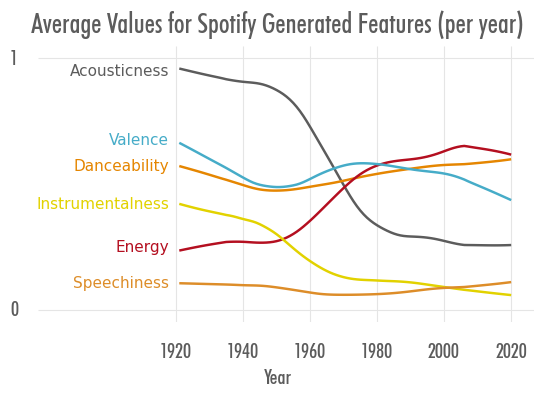

<ggplot: (125264389340)>

In [56]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "acousticness"), color=FMF_Pallette[0], span=.3, se=False)
 + annotate("text", label="Acousticness", x = 1918.0, y=0.95, color=FMF_Pallette[0], ha="right")
 + geom_smooth(aes(x = "yr_num", y = "danceability"), color=FMF_Pallette[4], size=1, span=.3, se=False)
 + annotate("text", label="Danceability", x = 1918.0, y=0.57, color=FMF_Pallette[4], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "energy"), color=FMF_Pallette[5], span=.3, se=False)
 + annotate("text", label="Energy", x = 1918.0, y=0.25, color=FMF_Pallette[5], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "instrumentalness"), color=FMF_Pallette[2], span=.3, se=False)
 + annotate("text", label="Instrumentalness", x = 1918.0, y=0.42, color=FMF_Pallette[2], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "speechiness"), color=FMF_Pallette[3], span=.3, se=False)
 + annotate("text", label="Speechiness", x = 1918.0, y=0.105, color=FMF_Pallette[3], ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "valence"), color=FMF_Pallette[1], span=.3, se=False)
 + annotate("text", label="Valence", x = 1918.0, y=0.675, color=FMF_Pallette[1], ha="right" )
 + scale_x_continuous(limits=(1885.5,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,1), breaks=[0,1])
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), 
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Spotify Generated Features (per year)")
 + labs(x="Year", y="",size=20)
 + coord_fixed(75)
)

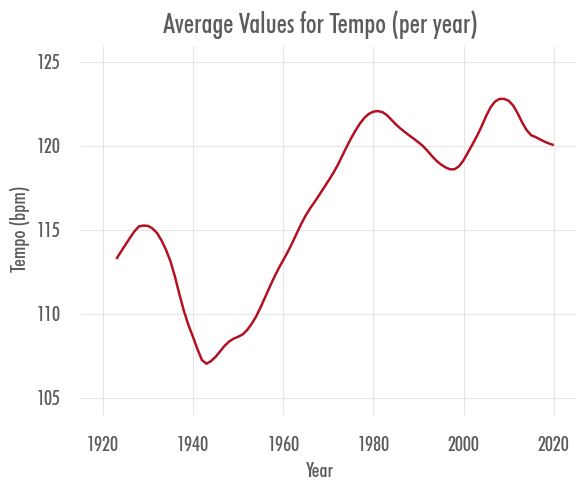

<ggplot: (125264213941)>

In [60]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "tempo"), color=FMF_Pallette[5], span=.125, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(105,125))
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Tempo (per year)")
 + labs(x="Year", y="Tempo (bpm)")
)

In [8]:
data_agg_1["duration_min"] = data_agg_1["duration_ms"].div(60000)


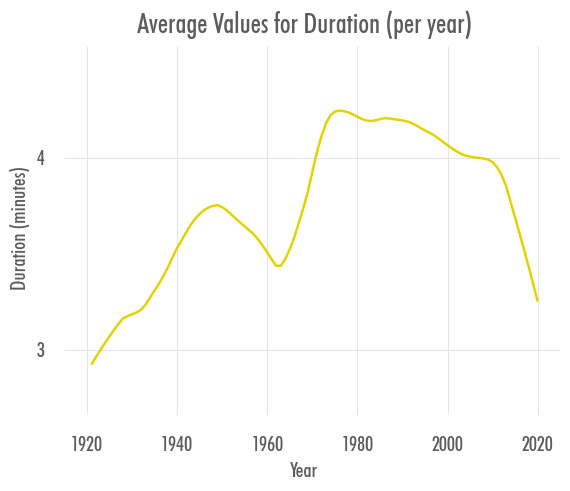

<ggplot: (125246709932)>

In [63]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "duration_min"), color=FMF_Pallette[2], span=.15, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(2.75,4.5), breaks = [3,4])
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Duration (per year)")
 + labs(x="Year", y="Duration (minutes)")
)

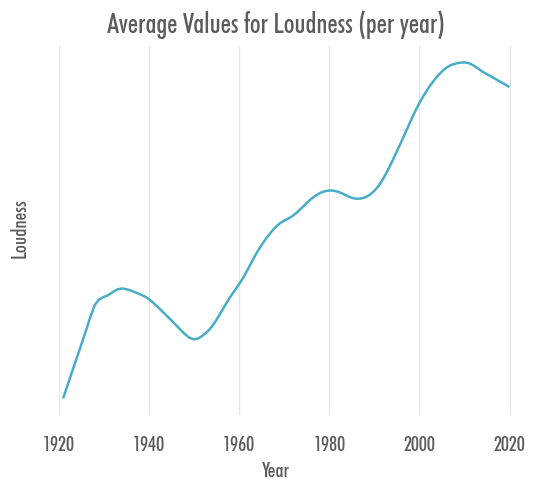

<ggplot: (125246758310)>

In [66]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "loudness"), color=FMF_Pallette[1], span=.15, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(),
         panel_grid_major_y=element_blank(),
         axis_text_y=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Average Values for Loudness (per year)")
 + labs(x="Year", y="Loudness")
)

In [11]:
key_distro_1["percentage100"] = key_distro_1["percentage"] * 100

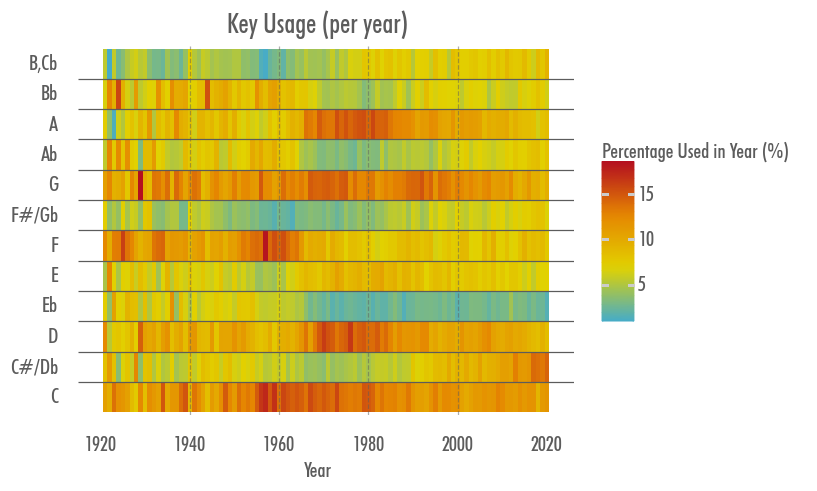

<ggplot: (125263675311)>

In [89]:
FMF_Pallette2 = ["#46ACC8","#E2D200", "#E58601", "#B40F20"]
# FMF_Pallette.reverse()

(ggplot(key_distro_1, aes(x = "yr_num", y = "key", fill = "percentage100")) 
 + geom_tile()
 + scale_x_continuous(limits=(1920,2021), breaks = range(1920,2021,20))
 + scale_y_discrete(breaks=range(0,12), labels=["C",
                                                "C#/Db",
                                                "D",
                                                "Eb",
                                                "E",
                                                "F",
                                                "F#/Gb",
                                                "G",
                                                "Ab",
                                                "A",
                                                "Bb",
                                                "B,Cb"])
 + geom_vline(xintercept=[1940,1960,1980,2000], linetype="dashed", color="#5C5C5C7F")
 + geom_hline(yintercept=np.array(range(1,12))+.5, color=FMF_Pallette[0])
#  + scale_fill_gradientn(["#500660","#05A8AA","#43E000"], name="Percentage Used in Year (%)",)
 + scale_fill_gradientn(FMF_Pallette2, name="Percentage Used in Year (%)",)
 + theme_minimal()
 + ggtitle("Key Usage (per year)")
 + labs(x="Year", y="")
 + theme(panel_grid_minor=element_blank(), 
         panel_grid_major=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
)

In [104]:
mode_distro_1["percentage100"] = mode_distro_1["percentage"] * 100
mode_distro_1 = mode_distro_1.append(pd.DataFrame({"year": [1921],
                                                           "mode": [0],
                                                           "number": [0],
                                                           "yr_num": [1921.0],
                                                           "percentage100": [0]}))

mode_distro_1.head()

,year,mode,number,percentage,yr_num,percentage100
0,1921,1,80,0.661157,1921.0,66.115702
0,1922,1,45,0.625000,1922.0,62.500000
0,1923,1,131,0.775148,1923.0,77.514793
0,1924,1,178,0.751055,1924.0,75.105485
0,1925,1,189,0.718631,1925.0,71.863118


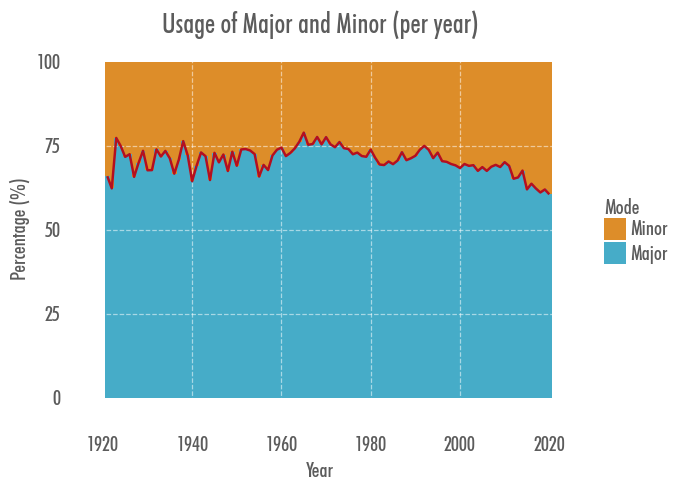

<ggplot: (125246156921)>

In [147]:
(ggplot(mode_distro_1, aes(x = "yr_num", y = "percentage100", fill = "mode")) 
 + geom_rect(xmin=1920.5,xmax=2020.5,ymin=0,ymax=100, fill=FMF_Pallette[3])
 + geom_bar(position="stack", stat="identity", width=1)
 + scale_x_continuous(limits=(1920,2021), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,100), breaks=[0,25,50,75,100])
 + scale_fill_manual(name="Mode", labels=["Minor", "Major"], values=[FMF_Pallette[3],FMF_Pallette[1]])
 + geom_vline(xintercept=[1940,1960,1980,2000], linetype="dashed", color="#ffffff88")
 + geom_hline(yintercept=[25,50,75], linetype="dashed", color="#ffffff88")
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), 
         panel_grid_major=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Usage of Major and Minor (per year)")
 + labs(x="Year", y="Percentage (%)", fill="Explicit?")
 + guides(color = guide_legend(reverse = True))
 + geom_line(aes(x = "yr_num", y = "percentage100"), color=FMF_Pallette[5],size=1)
)

In [110]:
explicit_distro_1["percentage100"] = explicit_distro_1["percentage"] * 100
explicit_distro_1 = explicit_distro_1.append(pd.DataFrame({"year": [1921],
                                                           "explicit": [1],
                                                           "number": [0],
                                                           "yr_num": [1921.0],
                                                           "percentage100": [0]}))

explicit_distro_1.head()

,year,explicit,number,percentage,yr_num,percentage100
0,1921,0,121,1.0,1921.0,100.0
0,1922,0,72,1.0,1922.0,100.0
0,1923,0,169,1.0,1923.0,100.0
0,1924,0,237,1.0,1924.0,100.0
0,1925,0,263,1.0,1925.0,100.0


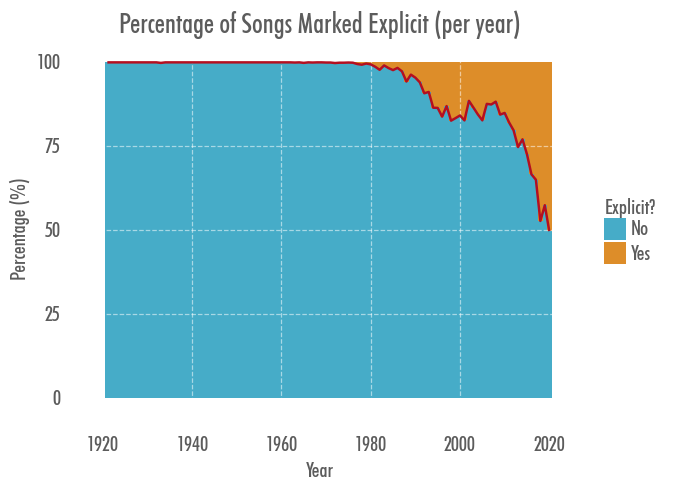

<ggplot: (125266341497)>

In [150]:
(ggplot(explicit_distro_1, aes(x = "yr_num", y = "percentage100", fill = "explicit")) 
 + geom_rect(xmin=1920.5,xmax=2020.5,ymin=0,ymax=100, fill=FMF_Pallette[3])
 + geom_bar(position="stack", stat="identity", width=1)
 + scale_x_continuous(limits=(1920,2021), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,100), breaks=[0,25,50,75,100])
 + scale_fill_manual(name="Explicit?", labels=["No", "Yes"], values=[FMF_Pallette[1],FMF_Pallette[3]])
 + geom_vline(xintercept=[1940,1960,1980,2000], linetype="dashed", color="#ffffff88")
 + geom_hline(yintercept=[25,50,75], linetype="dashed", color="#ffffff88")
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), 
         panel_grid_major=element_blank(),
         text=element_text(fontproperties=futura, color=FMF_Pallette[0], size=15),
         plot_title=element_text(size=20))
 + ggtitle("Percentage of Songs Marked Explicit (per year)")
 + labs(x="Year", y="Percentage (%)", fill="Explicit?")
 + guides(color = guide_legend(reverse = True))
 + geom_line(aes(x = "yr_num", y = "percentage100"), color=FMF_Pallette[5],size=1)
)

## 2- Can we predict if a track is major or minor given it's other characteristics?

In [17]:
data_2 = pd.read_csv("../Data/data.csv")
data_2.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


## 3- Can we classify the songs into different "contexts" in which they would be played?

In [18]:
data_3 = pd.read_csv("../Data/data.csv")
data_3.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
